In [1]:
%%time
%load_ext autoreload
from analysis_utils import *
from joblib import Parallel, delayed
import multiprocessing  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

#Growth rate = 3.0
#Computes the translation latencies from our model with simulations containing
#1 to 14 cognate ternary complexes in the voxel (14 to 42 not included because
#the probability of voxels with that number of cognates is ~0)
path = "/Users/Akshay/Documents/tRNAShuffle/data/"
ensmbl_latency_dict = dict()
rxndiff=dict()
scalingFactor = 200
NR_scaledrates = {'k1r':718*200/scalingFactor,'k2f':1475*200/scalingFactor,'k2r_nr':1120*200/scalingFactor,'k3_nr':6*200/scalingFactor,'k4':209*200/scalingFactor}


data = "191003_2210/"
for i in range(1,7):
    sim_i = computeTransportRxnTimes(path+data,100*(i-1),100*(i-1)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))

data = "191105_0908/"
for i in range(7,14):
    sim_i = computeTransportRxnTimes(path+data, 100*(i-1-6),100*(i-1-6)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))
    
#Experimentally obtained codon usage frequencies and tRNA abundances at growth rate = 2.5 dbl/hr
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
#pCodon_WT = gr25_pCodon
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)

Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
CPU times: user 46.6 s, sys: 853 ms, total: 47.5 s
Wall time: 48.4 s


In [2]:
##Compute the codon distribution and elongation latency of each gene weighted by transcript number
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map,gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map,gene_latency)
pCodon_WT = np.array(pCodon_transcriptome)

Removed  349  RNA species
4358
Removed  81  non-divisible by three genes
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fu

Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProtein

Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProteinsOnly didnt find a gene
Inconsistency: reduceGeneMap_fullProtein

Failed gene in transcriptome_dict in compute_transcript_distributions:  1
Failed gene in transcriptome_dict in compute_transcript_distributions:  2
Failed gene in transcriptome_dict in compute_transcript_distributions:  3
Failed gene in transcriptome_dict in compute_transcript_distributions:  4
Failed gene in transcriptome_dict in compute_transcript_distributions:  5
Failed gene in transcriptome_dict in compute_transcript_distributions:  6
Failed gene in transcriptome_dict in compute_transcript_distributions:  7
Failed gene in transcriptome_dict in compute_transcript_distributions:  8
Failed gene in transcriptome_dict in compute_transcript_distributions:  9
Failed gene in transcriptome_dict in compute_transcript_distributions:  10
Failed gene in transcriptome_dict in compute_transcript_distributions:  11
Failed gene in transcriptome_dict in compute_transcript_distributions:  12
Failed gene in transcriptome_dict in compute_transcript_distributions:  13
Failed gene in transcriptome_dict 

Failed gene in transcriptome_dict in compute_transcript_distributions:  116
Failed gene in transcriptome_dict in compute_transcript_distributions:  117
Failed gene in transcriptome_dict in compute_transcript_distributions:  118
Failed gene in transcriptome_dict in compute_transcript_distributions:  119
Failed gene in transcriptome_dict in compute_transcript_distributions:  120
Failed gene in transcriptome_dict in compute_transcript_distributions:  121
Failed gene in transcriptome_dict in compute_transcript_distributions:  122
Failed gene in transcriptome_dict in compute_transcript_distributions:  123
Failed gene in transcriptome_dict in compute_transcript_distributions:  124
Failed gene in transcriptome_dict in compute_transcript_distributions:  125
Failed gene in transcriptome_dict in compute_transcript_distributions:  126
Failed gene in transcriptome_dict in compute_transcript_distributions:  127
Failed gene in transcriptome_dict in compute_transcript_distributions:  128
Failed gene 

Failed gene in transcriptome_dict in compute_transcript_distributions:  225
Failed gene in transcriptome_dict in compute_transcript_distributions:  226
Failed gene in transcriptome_dict in compute_transcript_distributions:  227
Failed gene in transcriptome_dict in compute_transcript_distributions:  228
Failed gene in transcriptome_dict in compute_transcript_distributions:  229
Failed gene in transcriptome_dict in compute_transcript_distributions:  230
Failed gene in transcriptome_dict in compute_transcript_distributions:  231
Failed gene in transcriptome_dict in compute_transcript_distributions:  232
Failed gene in transcriptome_dict in compute_transcript_distributions:  233
Failed gene in transcriptome_dict in compute_transcript_distributions:  234
Failed gene in transcriptome_dict in compute_transcript_distributions:  235
Failed gene in transcriptome_dict in compute_transcript_distributions:  236
Failed gene in transcriptome_dict in compute_transcript_distributions:  237
Failed gene 

Failed gene in transcriptome_dict in compute_transcript_distributions:  348
Failed gene in transcriptome_dict in compute_transcript_distributions:  349
Failed gene in transcriptome_dict in compute_transcript_distributions:  350
Failed gene in transcriptome_dict in compute_transcript_distributions:  351
Failed gene in transcriptome_dict in compute_transcript_distributions:  352
Failed gene in transcriptome_dict in compute_transcript_distributions:  353
Failed gene in transcriptome_dict in compute_transcript_distributions:  354
Failed gene in transcriptome_dict in compute_transcript_distributions:  355
Failed gene in transcriptome_dict in compute_transcript_distributions:  356
Failed gene in transcriptome_dict in compute_transcript_distributions:  357
Failed gene in transcriptome_dict in compute_transcript_distributions:  358
Failed gene in transcriptome_dict in compute_transcript_distributions:  359
Failed gene in transcriptome_dict in compute_transcript_distributions:  360
Failed gene 

Failed gene in transcriptome_dict in compute_transcript_distributions:  456
Failed gene in transcriptome_dict in compute_transcript_distributions:  457
Failed gene in transcriptome_dict in compute_transcript_distributions:  458
Failed gene in transcriptome_dict in compute_transcript_distributions:  459
Failed gene in transcriptome_dict in compute_transcript_distributions:  460
Failed gene in transcriptome_dict in compute_transcript_distributions:  461
Failed gene in transcriptome_dict in compute_transcript_distributions:  462
Failed gene in transcriptome_dict in compute_transcript_distributions:  463
Failed gene in transcriptome_dict in compute_transcript_distributions:  464
Failed gene in transcriptome_dict in compute_transcript_distributions:  465
Failed gene in transcriptome_dict in compute_transcript_distributions:  466
Failed gene in transcriptome_dict in compute_transcript_distributions:  467
Failed gene in transcriptome_dict in compute_transcript_distributions:  468
Failed gene 

Failed gene in transcriptome_dict in compute_transcript_distributions:  581
Failed gene in transcriptome_dict in compute_transcript_distributions:  582
Failed gene in transcriptome_dict in compute_transcript_distributions:  583
Failed gene in transcriptome_dict in compute_transcript_distributions:  584
Failed gene in transcriptome_dict in compute_transcript_distributions:  585
Failed gene in transcriptome_dict in compute_transcript_distributions:  586
Failed gene in transcriptome_dict in compute_transcript_distributions:  587
Failed gene in transcriptome_dict in compute_transcript_distributions:  588
Failed gene in transcriptome_dict in compute_transcript_distributions:  589
Failed gene in transcriptome_dict in compute_transcript_distributions:  590
Failed gene in transcriptome_dict in compute_transcript_distributions:  591
Failed gene in transcriptome_dict in compute_transcript_distributions:  592
Failed gene in transcriptome_dict in compute_transcript_distributions:  593
Failed gene 

Failed gene in transcriptome_dict in compute_transcript_distributions:  691
Failed gene in transcriptome_dict in compute_transcript_distributions:  692
Failed gene in transcriptome_dict in compute_transcript_distributions:  693
Failed gene in transcriptome_dict in compute_transcript_distributions:  694
Failed gene in transcriptome_dict in compute_transcript_distributions:  695
Failed gene in transcriptome_dict in compute_transcript_distributions:  696
Failed gene in transcriptome_dict in compute_transcript_distributions:  697
Failed gene in transcriptome_dict in compute_transcript_distributions:  698
Failed gene in transcriptome_dict in compute_transcript_distributions:  699
Failed gene in transcriptome_dict in compute_transcript_distributions:  700
Failed gene in transcriptome_dict in compute_transcript_distributions:  701
Failed gene in transcriptome_dict in compute_transcript_distributions:  702
Failed gene in transcriptome_dict in compute_transcript_distributions:  703
Failed gene 

Failed gene in transcriptome_dict in compute_transcript_distributions:  805
Failed gene in transcriptome_dict in compute_transcript_distributions:  806
Failed gene in transcriptome_dict in compute_transcript_distributions:  807
Failed gene in transcriptome_dict in compute_transcript_distributions:  808
Failed gene in transcriptome_dict in compute_transcript_distributions:  809
Failed gene in transcriptome_dict in compute_transcript_distributions:  810
Failed gene in transcriptome_dict in compute_transcript_distributions:  811
Failed gene in transcriptome_dict in compute_transcript_distributions:  812
Failed gene in transcriptome_dict in compute_transcript_distributions:  813
Failed gene in transcriptome_dict in compute_transcript_distributions:  814
Failed gene in transcriptome_dict in compute_transcript_distributions:  815
Failed gene in transcriptome_dict in compute_transcript_distributions:  816
Failed gene in transcriptome_dict in compute_transcript_distributions:  817
Failed gene 

Failed gene in transcriptome_dict in compute_transcript_distributions:  916
Failed gene in transcriptome_dict in compute_transcript_distributions:  917
Failed gene in transcriptome_dict in compute_transcript_distributions:  918
Failed gene in transcriptome_dict in compute_transcript_distributions:  919
Failed gene in transcriptome_dict in compute_transcript_distributions:  920
Failed gene in transcriptome_dict in compute_transcript_distributions:  921
Failed gene in transcriptome_dict in compute_transcript_distributions:  922
Failed gene in transcriptome_dict in compute_transcript_distributions:  923
Failed gene in transcriptome_dict in compute_transcript_distributions:  924
Failed gene in transcriptome_dict in compute_transcript_distributions:  925
Failed gene in transcriptome_dict in compute_transcript_distributions:  926
Failed gene in transcriptome_dict in compute_transcript_distributions:  927
Failed gene in transcriptome_dict in compute_transcript_distributions:  928
Failed gene 

Failed gene in transcriptome_dict in compute_transcript_distributions:  1037
Failed gene in transcriptome_dict in compute_transcript_distributions:  1038
Failed gene in transcriptome_dict in compute_transcript_distributions:  1039
Failed gene in transcriptome_dict in compute_transcript_distributions:  1040
Failed gene in transcriptome_dict in compute_transcript_distributions:  1041
Failed gene in transcriptome_dict in compute_transcript_distributions:  1042
Failed gene in transcriptome_dict in compute_transcript_distributions:  1043
Failed gene in transcriptome_dict in compute_transcript_distributions:  1044
Failed gene in transcriptome_dict in compute_transcript_distributions:  1045
Failed gene in transcriptome_dict in compute_transcript_distributions:  1046
Failed gene in transcriptome_dict in compute_transcript_distributions:  1047
Failed gene in transcriptome_dict in compute_transcript_distributions:  1048
Failed gene in transcriptome_dict in compute_transcript_distributions:  1049

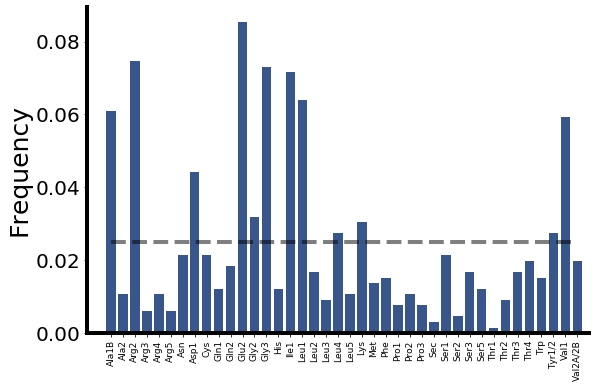

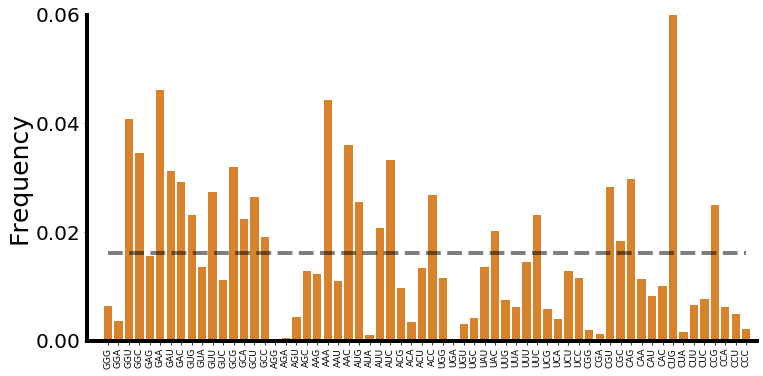

In [3]:
#plot frequency of tRNA vs. codon frequency plot for the new tRNA set vs old
tRNA_tags = ["Ala1B", "Ala2", "Arg2", "Arg3", "Arg4", "Arg5", "Asn", "Asp1", "Cys", "Gln1", "Gln2", \
"Glu2", "Gly2", "Gly3", "His", "Ile1", "Leu1", "Leu2", "Leu3", "Leu4", "Leu5", "Lys", \
"Met", "Phe", "Pro1", "Pro2", "Pro3", "Sec", "Ser1", "Ser2", "Ser3", "Ser5", "Thr1", \
"Thr2", "Thr3", "Thr4", "Trp", "Tyr1/2", "Val1", "Val2A/2B"]

codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']

fig,ax0 = plt.subplots(figsize=(9,6))
ax0.bar(np.arange(40),gr25_ptRNA,color='#39568CFF',width=0.8)
ax0.plot(np.arange(40),[1/40]*40,color='black',linewidth=4,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_tags,rotation='vertical')
ax0.set_xlim(-2,40)

fig,ax = plt.subplots(figsize=(12,6))
ax.bar(np.arange(62),pCodon_WT,color='#d8832b',width=0.8)
ax.plot(np.arange(62),[1/62]*62,color='black',linewidth=4,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_tags,rotation='vertical')
ax.set_xlim(-2,62)
ax.set_ylim(0,0.06)
plt.yticks([0.0,0.02,0.04,0.06])

for ax in [ax0,ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylabel('Frequency',fontsize=25)

[192.1388164759783]
213.35167616338012 3.612016064614552
[1.11040382]
z-score:  [5.87285862]
p-value [2.14171879e-09]


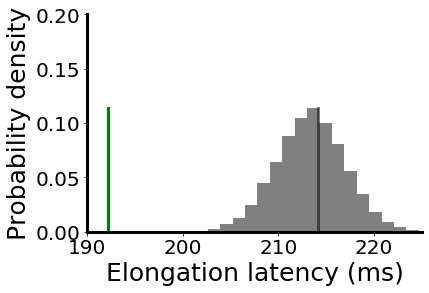

In [4]:
#Compute elongation latency for uniform tRNA with WT codon
ptRNA_uniform = np.ones(len(gr25_ptRNA))/sum(np.ones(len(gr25_ptRNA)))
elongt_WTtRNA_WTcodon, std = computeElongationLatency(gr25_ptRNA,pCodon_WT,ensmbl_latency_dict)
print(elongt_WTtRNA_WTcodon)
elongt_uniformtRNA_WTcodon, std = computeElongationLatency(ptRNA_uniform,pCodon_WT,ensmbl_latency_dict)

#### Plot tRNA shuffling
import matplotlib.pyplot as plt
import scipy.stats

elongt_list=np.load('./data/UniformRandomtRNA_WTCodonUsage_10ksample_elongt.npy')

fig,ax = plt.subplots(1,1)
hist=ax.hist(elongt_list,20,color='grey',density=True)
ax.plot([elongt_WTtRNA_WTcodon]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')
ax.plot([elongt_uniformtRNA_WTcodon]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='black',alpha=0.5)

print(np.mean(elongt_list), np.std(elongt_list))
print(np.mean(elongt_list)/elongt_WTtRNA_WTcodon)
print('z-score: ', (np.mean(elongt_list)-elongt_WTtRNA_WTcodon)/np.std(elongt_list))
print('p-value', scipy.stats.norm.sf(abs((np.mean(elongt_list)-elongt_WTtRNA_WTcodon)/np.std(elongt_list))))
for _,axes in enumerate([ax]):
    axes.spines['left'].set_linewidth(3)
    axes.spines['bottom'].set_linewidth(3)
    axes.spines['top'].set_linewidth(0)
    axes.spines['right'].set_linewidth(0)
    axes.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylim(0,0.2)
    ax.set_xlim(190,225)
    ax.set_xlabel('Elongation latency (ms)',size=25)
    ax.set_ylabel('Probability density',size=25)

199.95661350633017 2.0238369526054067
[1.04068828]
z-score:  [3.86285912]
p-value [5.60338215e-05]


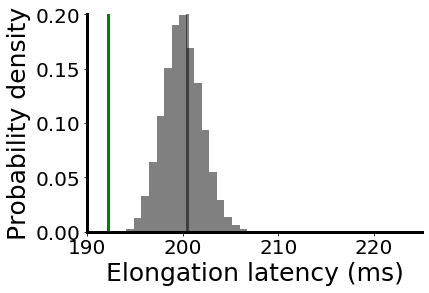

In [5]:
#Compute elongation latency for uniform codon with WT tRNA
pCodon_uniform = np.ones(len(gr25_pCodon))/sum(np.ones(len(gr25_pCodon)))

#List of synonymous codons based on codon label order
syn_codon_list = [[0,1,2,3],[4,5],[6,7],[8,9,10,11],[12,13,14,15],[16,17,46,47,48,49],[18,19,42,43,44,45],
              [20,21],[22,23],[24],[25,26,27],[28,29,30,31],[32],[33],[34,35],[36,37],[38,39,54,55,56,57],[40,41],
              [50,51],[52,53],[58,59,60,61]]

for syn_codons in syn_codon_list:
    pCodon_uniform[syn_codons] = sum(pCodon_WT[syn_codons])/sum(pCodon_uniform[syn_codons])*pCodon_uniform[syn_codons]
pCodon_uniform = pCodon_uniform/np.sum(pCodon_uniform)

elongt_WTtRNA_uniformcodon, std = computeElongationLatency(gr25_ptRNA,pCodon_uniform,ensmbl_latency_dict)


#### Plot tRNA shuffling
import matplotlib.pyplot as plt
import scipy.stats

elongt_list=np.load('./data/WTtRNA_UniformRandomCodonUsage_10ksample_elongt.npy')

fig,ax = plt.subplots(1,1)
hist=ax.hist(elongt_list,20,color='grey',density=True)
ax.plot([elongt_WTtRNA_WTcodon]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')
ax.plot([elongt_WTtRNA_uniformcodon]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='black',alpha=0.5)

print(np.mean(elongt_list), np.std(elongt_list))
print(np.mean(elongt_list)/elongt_WTtRNA_WTcodon)
print('z-score: ', (np.mean(elongt_list)-elongt_WTtRNA_WTcodon)/np.std(elongt_list))
print('p-value', scipy.stats.norm.sf(abs((np.mean(elongt_list)-elongt_WTtRNA_WTcodon)/np.std(elongt_list))))
for _,axes in enumerate([ax]):
    axes.spines['left'].set_linewidth(3)
    axes.spines['bottom'].set_linewidth(3)
    axes.spines['top'].set_linewidth(0)
    axes.spines['right'].set_linewidth(0)
    axes.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylim(0,0.20)
    ax.set_xlim(190,225)
    ax.set_xlabel('Elongation latency (ms)',size=25)
    ax.set_ylabel('Probability density',size=25)

In [6]:
### trna frequency vs codon frequency, Uniform random tRNA frequency & Uniform random codon usage 


R^2:  0.014732570854224414
slope:  0.10291757158350666


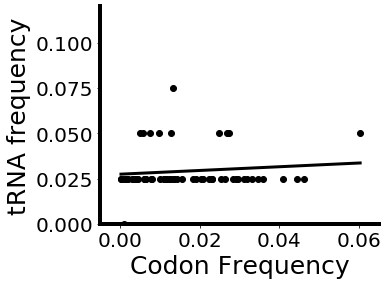

In [7]:
ptRNA_uniform = np.random.uniform(min(gr25_ptRNA),max(gr25_ptRNA),len(gr25_ptRNA))
ptRNA_uniform = np.ones(len(gr25_ptRNA))/sum(np.ones(len(gr25_ptRNA)))
#Random codon
syn_codon_list = [[0,1,2,3],[4,5],[6,7],[8,9,10,11],[12,13,14,15],[16,17,46,47,48,49],[18,19,42,43,44,45],
              [20,21],[22,23],[24],[25,26,27],[28,29,30,31],[32],[33],[34,35],[36,37],[38,39,54,55,56,57],[40,41],
              [50,51],[52,53],[58,59,60,61]]
        
pCodon_uniform = np.zeros(len(gr25_pCodon))

for syn_codons in syn_codon_list:
    pCodon_uniform[syn_codons] = np.random.uniform(min(gr25_Codon),max(gr25_Codon),len(syn_codons))
    pCodon_uniform[syn_codons] = sum(pCodon_WT[syn_codons])/sum(pCodon_uniform[syn_codons])*pCodon_uniform[syn_codons]

ptRNA_dict, pcodon_dict, codon_dict, codon_labels, pCodon = cognateDistrib(ptRNA_uniform,pCodon_WT,True)

#Sort codons by frequency; then compute their corresponding tRNA frequencies
pcodon_sorted = sorted(pcodon_dict.items(),key=lambda kv: kv[1])[::-1]
codon_sorted = [x[0] for x in pcodon_sorted]
pcodon_sorted = [x[1] for x in pcodon_sorted]

tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted = [sum(ptRNA_dict[tRNA] for tRNA in codon_dict[codon]) for codon in codon_sorted]

fig,ax = plt.subplots(figsize=(5,4))
ax.scatter(pcodon_sorted,ptRNA_sorted,color='black',label = 'Protein-coding codon')

#Fit scatter
y_model,SS_err,_,_,_ = np.polyfit(pcodon_sorted,ptRNA_sorted,1,full=True)
y_hat = np.polyval(y_model,pcodon_sorted)
x_sweep_i = np.linspace(min(pcodon_sorted),max(pcodon_sorted),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,linewidth=3,color='black')
print("R^2: ",calc_R2(pcodon_sorted,ptRNA_sorted,y_hat))

slope, intercept = np.polyfit(pcodon_sorted,ptRNA_sorted,1)
print("slope: ", slope)

ax.set_xlim(-0.005,0.065)
ax.set_ylim(0,0.12)
ax.set_xlabel('Codon Frequency',fontsize=25)
ax.set_ylabel('tRNA frequency',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)


### trna frequency vs codon frequency, WT tRNA frequency & WT codon usage 


R^2:  0.3496420739083743
slope:  1.103191852444764


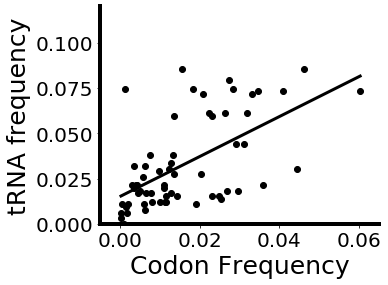

In [8]:
ptRNA_dict, pcodon_dict, codon_dict, codon_labels, pCodon = cognateDistrib(gr25_ptRNA,pCodon_WT,True)

#Sort codons by frequency; then compute their corresponding tRNA frequencies
pcodon_sorted = sorted(pcodon_dict.items(),key=lambda kv: kv[1])[::-1]
codon_sorted = [x[0] for x in pcodon_sorted]
pcodon_sorted = [x[1] for x in pcodon_sorted]

tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted = [sum(ptRNA_dict[tRNA] for tRNA in codon_dict[codon]) for codon in codon_sorted]

fig,ax = plt.subplots(figsize=(5,4))
ax.scatter(pcodon_sorted,ptRNA_sorted,color='black',label = 'Protein-coding codon')

#Fit scatter
y_model,SS_err,_,_,_ = np.polyfit(pcodon_sorted,ptRNA_sorted,1,full=True)
y_hat = np.polyval(y_model,pcodon_sorted)
x_sweep_i = np.linspace(min(pcodon_sorted),max(pcodon_sorted),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,linewidth=3,color='black')
print("R^2: ",calc_R2(pcodon_sorted,ptRNA_sorted,y_hat))

slope, intercept = np.polyfit(pcodon_sorted,ptRNA_sorted,1)
print("slope: ", slope)

ax.set_xlim(-0.005,0.065)
ax.set_ylim(0,0.12)
ax.set_xlabel('Codon Frequency',fontsize=25)
ax.set_ylabel('tRNA frequency',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
